## TODO:
 - Unify image shapes
 - Visualize few cells
 - Label data (by directory path?)
 - Split data into training and test sets
 - Basic CNN
 - More elaborate CNNs
 - Hyperopt? (Hyperas)
 - Transfer Learning?

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image as img

import matplotlib.pyplot as plt
%matplotlib inline

## Load Images

In [2]:
para = np.array([np.array(img.open('./cell_images/Parasitized/' + image)) for image in sorted(os.listdir(os.getcwd() + '/cell_images/Parasitized/')) if image.startswith('C')])

In [3]:
unpara = np.array([np.array(img.open('./cell_images/Uninfected/' + image)) for image in sorted(os.listdir(os.getcwd() + '/cell_images/Uninfected/')) if image.startswith('C')])

## Unify images shapes

In [21]:
shapes = [image.shape for image in para[range(len(para))]]
len(set(shapes))

TypeError: unhashable type: 'numpy.ndarray'

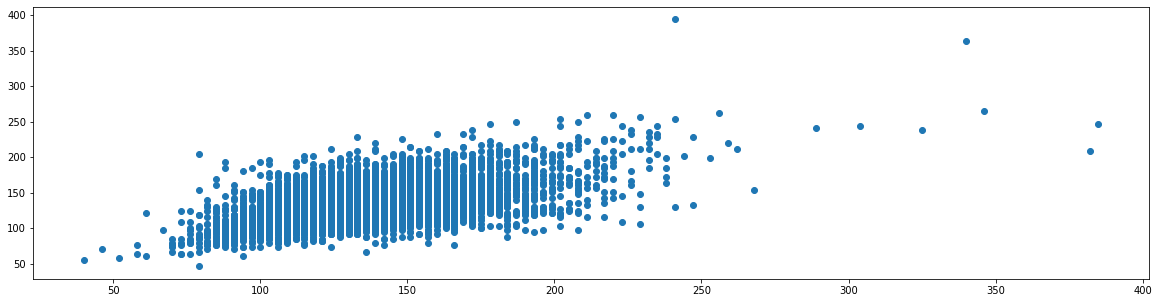

In [24]:
shapes = np.array(shapes)
plt.figure(figsize=(20, 5))
plt.scatter(shapes[:, 0], shapes[:, 1]);

In [17]:
un_shapes = [image.shape for image in unpara[range(len(unpara))]]
len(set(un_shapes))

1207

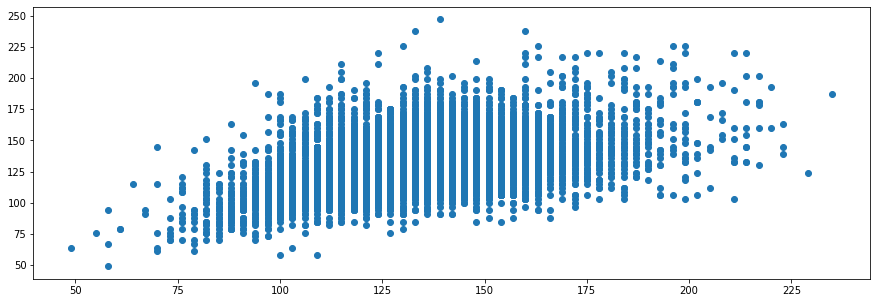

In [23]:
un_shapes = np.array(un_shapes)
plt.figure(figsize=(15, 5))
plt.scatter(un_shapes[:, 0], un_shapes[:, 1]);